In [1]:
import torch
from torch import nn
import warnings
warnings.filterwarnings('ignore')

Cross-Correlation

In convolutional layer, an input tensor and a kernel tensor are
combined to produce an output tensor through a cross-correlation operation. In the two-dimensional cross-correlation operation, we begin with the convolution window
positioned at the upper-left corner of the input tensor and slide it across the input tensor,
both from left to right and top to bottom. When the convolution window slides to a certain position, the input subtensor contained in that window and the kernel tensor are multiplied
elementwise and the resulting tensor is summed up yielding a single scalar value. This
result gives the value of the output tensor at the corresponding location.

When the kernel has width and height greater than 1, we can only properly compute the cross-
correlation for locations where the kernel fits wholly within the image, the output size is
given by the input size 𝑛<sub>h</sub> × 𝑛<sub>w</sub> minus the size of the convolution kernel 𝑘 <sub>h</sub> × 𝑘 <sub>w</sub> via
(𝑛<sub>h</sub> − 𝑘 <sub>h</sub> + 1) × (𝑛<sub>w</sub> − 𝑘 <sub>w</sub> + 1).

In [2]:
def cross_corr2d(X,K):
    kh, kw = K.shape
    Y = torch.zeros((X.shape[0] - kh + 1, X.shape[1] - kw + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i,j] = (X[i:i+kh, j:j+kw]*K).sum()

    return Y

In [3]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
cross_corr2d(X,K)

tensor([[19., 25.],
        [37., 43.]])

Object Detection in Images

In [4]:
X = torch.ones((6,8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [5]:
y = X.numpy()
y

array([[1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.]], dtype=float32)

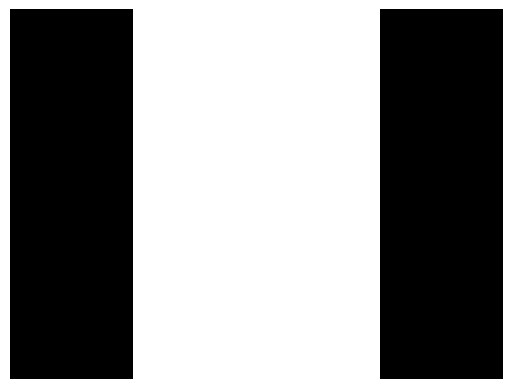

In [6]:
import matplotlib.pyplot as plt

plt.imshow(y, cmap='binary')
plt.axis("off")  # Hide axes
plt.show()

In [7]:
# kernel

K = torch.tensor([[1,-1]])

# cross-correlation of image X with kernel K
Y = cross_corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

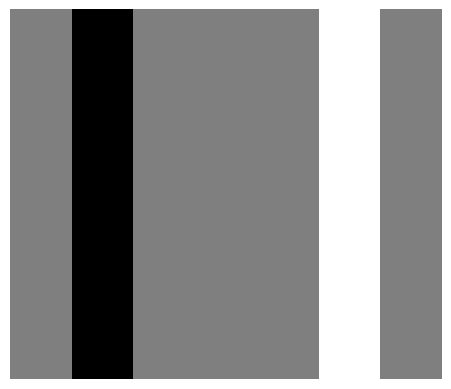

In [8]:
plt.imshow(Y.numpy(), cmap='binary')
plt.axis("off")  # Hide axes
plt.show()

Cross-Correlation in Convolution

In [9]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return cross_corr2d(x, self.weight) + self.bias
    
net = Conv2D([2,2])
print(net.weight, net.bias)

Parameter containing:
tensor([[0.9989, 0.0064],
        [0.4659, 0.7675]], requires_grad=True) Parameter containing:
tensor([0.], requires_grad=True)


### Lazy Reverse Implementation to find Kernel Values for Boundary Detection


In [10]:
conv2d = nn.LazyConv2d(1, kernel_size=(1,2), bias=False)
X = X.reshape((1,1,6,8))
Y = Y.reshape((1,1,6,7))
print('X:',X)
print('Y:',Y)

X: tensor([[[[1., 1., 0., 0., 0., 0., 1., 1.],
          [1., 1., 0., 0., 0., 0., 1., 1.],
          [1., 1., 0., 0., 0., 0., 1., 1.],
          [1., 1., 0., 0., 0., 0., 1., 1.],
          [1., 1., 0., 0., 0., 0., 1., 1.],
          [1., 1., 0., 0., 0., 0., 1., 1.]]]])
Y: tensor([[[[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.]]]])


In [11]:
lr = 3e-2
for i in range(10):
    Y_hat = conv2d(X)
    loss = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    loss.sum().backward()
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i+1) % 2 == 0:
        print(f'epoch {i+1}, loss = {loss.sum():.3f}')

epoch 2, loss = 12.526
epoch 4, loss = 2.233
epoch 6, loss = 0.429
epoch 8, loss = 0.094
epoch 10, loss = 0.025


In [12]:
conv2d.weight.data

tensor([[[[ 0.9948, -0.9692]]]])

### Padding 

Since we typically use small kernels, for any given convolution we might only lose a few
pixels but this can add up as we apply many successive convolutional layers. One straight-
forward solution to this problem is to add extra pixels of filler around the boundary of our
input image, thus increasing the effective size of the image. Typically, we set the values of
the extra pixels to zero.

In general, if we add a total of 𝑝 <sub>h</sub> rows of padding (roughly half on top and half on bottom)
and a total of 𝑝 <sub>w</sub> columns of padding (roughly half on the left and half on the right), the
output shape will be


(𝑛<sub>h</sub> − 𝑘 <sub>h</sub> + 𝑝 <sub>h</sub> + 1) × (𝑛<sub>w</sub> − 𝑘 <sub>w</sub> + 𝑝 <sub>w</sub> + 1)

In [13]:
# suppose an image tensor as (1,1,8,8)
# (number of examples, number of channels, image height, image width)
X = torch.rand(size=(1,1,8,8))
conv2d_withoutpad = nn.LazyConv2d(out_channels=1,kernel_size=3)
y_nopadding = conv2d_withoutpad(X)
conv2d_pad = nn.LazyConv2d(out_channels=1,kernel_size=3, padding=1)
y_withpadding = conv2d_pad(X)
print('Without padding output shape:', y_nopadding.shape)
print('With padding output shape: ',y_withpadding.shape)

Without padding output shape: torch.Size([1, 1, 6, 6])
With padding output shape:  torch.Size([1, 1, 8, 8])


### Stride

When computing the cross-correlation, we start with the convolution window at the upper-
left corner of the input tensor, and then slide it over all locations both down and to the
right.

Either for computational efficiency or because we wish to downsample, we move our window more than one element at a time, skipping the intermediate locations.
This is particularly useful if the convolution kernel is large since it captures a large area of the underlying image. We refer to the number of rows and columns traversed per slide as stride.

In general, when the stride for the height is 𝑠h and the stride for the width is 𝑠<sub>w</sub> , the output
shape is

[(𝑛<sub>h</sub> − 𝑘 <sub>h</sub> + 𝑝 <sub>h</sub> + 𝑠<sub>h</sub> )/𝑠<sub>h</sub>]× [(𝑛<sub>w</sub> − 𝑘 <sub>w</sub> + 𝑝 <sub>w</sub> + 𝑠<sub>w</sub> )/𝑠<sub>w</sub> ].

In [14]:
conv2d = nn.LazyConv2d(out_channels=1, kernel_size=3, padding=(0, 1), stride=(3, 4))
conv2d(X).shape

torch.Size([1, 1, 2, 2])

### Multiple Input & Output Channels

For images there are three channels (R,G,B). Similarly, the output of hidden layers of CNN have multiple channels also known as feature maps.  Assuming that the number of channels for the input data is 𝑐<sub>i</sub> , the number of input channels of the convolution kernel also needs to be 𝑐<sub>i</sub>

These 𝑐<sub>i</sub> tensors together yields a convolution kernel of
shape 𝑐<sub>i</sub> × 𝑘<sub>h</sub> × 𝑘<sub>w</sub>

In [17]:
def corr2d_multi_input(X,K):
    return sum(cross_corr2d(x,k) for x, k in zip(X,K))

X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
[[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

print('(c, nh, nw): ',X.shape) # 
print('(c, kh, kw): ',K.shape) # 
corr2d_multi_input(X, K)

(c, nh, nw):  torch.Size([2, 3, 3])
(c, kh, kw):  torch.Size([2, 2, 2])


tensor([[ 56.,  72.],
        [104., 120.]])

To get an output with multiple channels, we can create
a kernel tensor of shape 

𝑐<sub>i</sub> × 𝑘<sub>h</sub> × 𝑘<sub>w</sub> 

for every output channel. We concatenate them on the output channel dimension, so that the shape of the convolution kernel is

 𝑐<sub>o</sub> × 𝑐<sub>i</sub> × 𝑘<sub>h</sub> × 𝑘<sub>w</sub> .

In cross-correlation operations, the result on each output channel is calculated from the
convolution kernel corresponding to that output channel and takes input from all channels
in the input tensor.

In [19]:
def corr2d_multi_in_out(X, K):
    return torch.stack([corr2d_multi_input(X, k) for k in K], 0)

In [20]:
K = torch.stack((K, K + 1, K + 2), 0)
K.shape

torch.Size([3, 2, 2, 2])

In [21]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

### 1x1 Convolution Using Cross Multiplication

In [22]:
def corr2d_multi_in_out_1x1(X,K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    Y = torch.matmul(K,X)
    return Y.reshape((c_o, h, w))


In [26]:
X = torch.normal(0, 1, (3, 3, 3))
print(X)

tensor([[[ 0.2967, -1.5985, -0.5942],
         [ 0.3021, -0.1001,  0.2396],
         [ 0.0975, -2.1947, -0.4982]],

        [[-0.4016, -0.0238, -0.6497],
         [-0.8970,  0.3027, -1.5630],
         [-0.3733, -1.0531,  1.8403]],

        [[-2.1665, -0.4649,  0.2601],
         [ 0.6142,  1.2124, -0.0661],
         [ 1.2056, -0.2060,  0.2802]]])


In [27]:
K = torch.normal(0, 1, (2, 3, 1, 1))
print(K)


tensor([[[[-0.8196]],

         [[ 1.4372]],

         [[ 0.7404]]],


        [[[-0.3027]],

         [[-0.2551]],

         [[-0.4499]]]])


In [28]:
Y1 = corr2d_multi_in_out_1x1(X, K)
print(Y1)

tensor([[[-2.4244,  0.9317, -0.2540],
         [-1.0819,  1.4147, -2.4916],
         [ 0.2762,  0.1329,  3.2606]],

        [[ 0.9872,  0.6991,  0.2286],
         [-0.1390, -0.5923,  0.3558],
         [-0.4766,  1.0256, -0.4446]]])


In [29]:
print(X.shape, K.shape, Y1.shape)

torch.Size([3, 3, 3]) torch.Size([2, 3, 1, 1]) torch.Size([2, 3, 3])


### Pooling

Pooling operators are deterministic, typically calculating either the maximum or the aver-
age value of the elements in the pooling window. These operations are called maximum
pooling (max-pooling for short) and average pooling, respectively

In [30]:
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode=='max':
                Y[i,j] = X[i:i+p_h, j: j+p_w].max()

            elif mode=='avg':
                Y[i,j] = X[i:i+p_h, j: j+p_w].mean()
    return Y

In [31]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [32]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

### Pooling with Padding and Stride

In [33]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [34]:
pool2d = nn.MaxPool2d(kernel_size=3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [35]:
pool2d = nn.MaxPool2d(kernel_size=(2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [36]:
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [37]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

### References:
Dive into Deep Learning: https://d2l.ai/